<a href="https://colab.research.google.com/github/idnchain/isy503-group3-assessment3-web-app/blob/main/ISY503_Group_3_Assessment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Install all necessary library (Tensorflow, Keras, pandas, numpy)

In [ ]:
%reset -f

# data module
import numpy as np
import pandas as pd
import math
import os
from sklearn.model_selection import train_test_split

# machine learning module
import re
import pickle
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


EXTRACTED_DIR = "sorted_data_acl"
TARBALL = "domain_sentiment_data.tar.gz"
DOWNLOAD_URL = "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"

'''
! wget "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
! tar -xzf "/content/domain_sentiment_data.tar.gz"
print ("Top-level after extract:")
!ls'''

# Case 1: Extracted dataset already exists
if os.path.exists(EXTRACTED_DIR):
    print(f"Dataset already extracted in folder: '{EXTRACTED_DIR}' — skipping download.")

# Case 2: Tarball exists but extraction hasn't happened yet
elif os.path.exists(TARBALL):
    print(f"Tarball '{TARBALL}' found — extracting now...")
    !tar -xzf {TARBALL}
    print("Extraction complete.")

# Case 3: Neither tarball nor extracted folder exists → download & extract
else:
    print("Dataset not found — downloading...")
    !wget -q {DOWNLOAD_URL}
    print("Download complete — extracting now...")
    !tar -xzf {TARBALL}
    print("Extraction complete.")

print("\nTop-level after setup:")
!ls -lh

Dataset not found — downloading...
Download complete — extracting now...
Extraction complete.

Top-level after setup:
total 30M
-rw-r--r-- 1 root root  30M Feb 15  2009 domain_sentiment_data.tar.gz
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
drwxr-xr-x 6 root root 4.0K Dec  2 12:22 sorted_data_acl


# To Do 1: Data Preprocessing


1. Load dataset
2. Clean + Preprocess dataset (punctuation, spelling, etc)
3. Remove outliers
4. Encode labels
5. Tokenise text
6. Split training and testing data


In [ ]:
from IPython.core.magics import NamespaceMagics
'''import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
'''
# 1. CONFIG
os.makedirs("processed_data", exist_ok=True)
os.makedirs("models", exist_ok=True)
BASE_DIR = "sorted_data_acl"
DOMAINS = ["books", "dvd", "electronics", "kitchen_&_housewares"]

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LEN = 200
MIN_TOKENS = 3

os.makedirs("models", exist_ok=True)
os.makedirs("processes_data", exist_ok=True)

# 2. LOAD ALL LABELLED REVIEWS

def load_reviews(path):
    # Read review files where reviews are seperated by blank lines
    with open(path, "r", encoding="latin-1") as f:
        data = f.read()
    reviews = [r.strip() for r in data.split("\n\n") if len(r.strip()) > 0]
    return reviews

all_texts = []
all_labels = []


for domain in DOMAINS:
  domain_path = os.path.join(BASE_DIR, domain)

  pos_path = os.path.join(domain_path, "positive.review")
  neg_path = os.path.join(domain_path, "negative.review")

  print(f"Loading domain : {domain}")
  print (" ", pos_path)
  print (" ", neg_path)

  pos_reviews = load_reviews(pos_path)
  neg_reviews = load_reviews(neg_path)

 # Append labelled data: 1 = positive, 0 = negative
  all_texts.extend(pos_reviews)
  all_labels.extend([1]* len(pos_reviews))

  all_texts.extend(neg_reviews)
  all_labels.extend([0]* len(neg_reviews))

print("\n====================================")
print("Loaded labelled samples:", len(all_texts))
print("  Positive:", sum(all_labels))
print("  Negative:", len(all_labels) - sum(all_labels))
print("====================================\n")

# 3. BUILD DATAFRAME & CLEAN TEXT

df = pd.DataFrame({
    "text": all_texts,
    "label": all_labels
})

def clean_text(text: str) -> str:
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Keep only letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)


# Remove very short reviews after cleaning
df["token_count"] = df["clean_text"].str.split().apply(len)
df = df[df["token_count"] >= MIN_TOKENS].copy()


print("After cleaning & outlier removal:", df.shape)
print(df[["clean_text", "label"]].head())

# 4. TRAIN / VALIDATION / TEST SPLIT

X = df["clean_text"].values
y = df["label"].values

# First: train + temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Then: split temp into val & test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("\nSplit sizes:")
print("  Train:", len(X_train))
print("  Val:  ", len(X_val))
print("  Test: ", len(X_test))

# 5. TOKENIZER & PADDING


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(
    X_train_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post'
)
X_val_pad = pad_sequences(
    X_val_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post'
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating='post'
)

print("\nPadded shapes:")
print("  Train:", X_train_pad.shape)
print("  Val:  ", X_val_pad.shape)
print("  Test: ", X_test_pad.shape)


# 6. SAVE TOKENIZER + SPLITS

# Save tokenizer
tokenizer_path = "models/tokenizer.pkl"
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Save train/val/test arrays
splits_path = "processed_data/train_val_test.npz"
np.savez_compressed(
    splits_path,
    X_train=X_train_pad, y_train=y_train,
    X_val=X_val_pad,   y_val=y_val,
    X_test=X_test_pad, y_test=y_test
)

print("\nSaved tokenizer →", tokenizer_path)
print("Saved splits    →", splits_path)


Loading domain : books
  sorted_data_acl/books/positive.review
  sorted_data_acl/books/negative.review
Loading domain : dvd
  sorted_data_acl/dvd/positive.review
  sorted_data_acl/dvd/negative.review
Loading domain : electronics
  sorted_data_acl/electronics/positive.review
  sorted_data_acl/electronics/negative.review
Loading domain : kitchen_&_housewares
  sorted_data_acl/kitchen_&_housewares/positive.review
  sorted_data_acl/kitchen_&_housewares/negative.review

Loaded labelled samples: 10683
  Positive: 5630
  Negative: 5053

After cleaning & outlier removal: (10414, 4)
                                          clean_text  label
0  one of the best crichton novels joseph m spher...      1
1  the story revolves around a man named norman j...      1
2  this novel does not have the research that som...      1
3  i would strongly recommend this book the medic...      1
4  beautiful june sarah silva sar san diego ca us...      1

Split sizes:
  Train: 7289
  Val:   1562
  Test:  1563

Pa

# To do 2: Baseline Model
1. Build basic model
2. Train and plot accuracy/loss
3. Evaluate using test set


Training samples (TF-IDF vectorized): (7289, 5000)
Testing samples (TF-IDF vectorized): (1563, 5000)
Baseline Accuracy: 0.7523992322456814

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       739
           1       0.75      0.79      0.77       824

    accuracy                           0.75      1563
   macro avg       0.75      0.75      0.75      1563
weighted avg       0.75      0.75      0.75      1563


Confusion Matrix:
[[523 216]
 [171 653]]


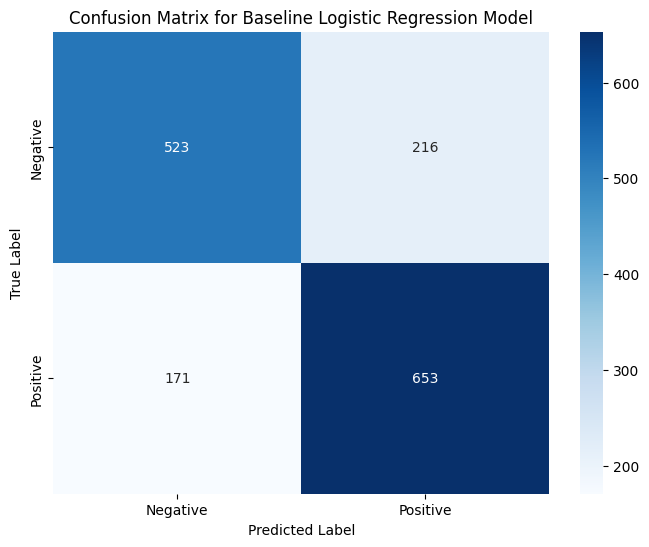

In [ ]:
# You can start training by loading the processed arrays from
# "processed_data/train_val_test.npz"
# and feeding X_train, y_train (plus validation data)
# into a Keras model built with an Embedding layer, LSTM (or GRU), and a
# final Dense sigmoid output using binary crossentropy loss.

# To Do 2: Baseline Model

# 1. Prepare data for Baseline Model (Logistic Regression)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add MAX_VOCAB_SIZE definition here for robustness
MAX_VOCAB_SIZE = 20000 # Defined in cell PL1ih-IPS4WJ

# Use X_train, X_test, y_train, y_test already defined in the previous cell
# These X_train, X_test are arrays of clean text strings.

MAX_VOCAB_SIZE = 5000   # or 3000, 10000 — any value is fine for a baseline

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_VOCAB_SIZE)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Training samples (TF-IDF vectorized):", X_train_tfidf.shape)
print("Testing samples (TF-IDF vectorized):", X_test_tfidf.shape)

# 2. Baseline Model – Logistic Regression
baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train_tfidf, y_train)

# 3. Predictions
y_pred = baseline_model.predict(X_test_tfidf)

# 4. Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualize the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Baseline Logistic Regression Model')
plt.show()

*The baseline model uses TF–IDF features with a Logistic Regression classifier. It achieves around 75% accuracy on the test set, providing a simple but effective reference point to compare against the improved neural network model in To do 3.*

# To do 3: Model Improvement


# Model Improvement using pre-trained GloVe Embeddings
1. Define neural network architecture
2. Add dropout
3. Train & evaluate

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
import zipfile

# 1. Define constants for GloVe and handle download/extraction
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP_FILE = "glove.6B.zip"
GLOVE_DIR = "glove_data"
GLOVE_TXT_FILE = "glove.6B.100d.txt"
EMBEDDING_DIM = 100 # As specified for GloVe

os.makedirs(GLOVE_DIR, exist_ok=True)
zip_path = os.path.join(GLOVE_DIR, GLOVE_ZIP_FILE)
txt_path = os.path.join(GLOVE_DIR, GLOVE_TXT_FILE)

if not os.path.exists(txt_path):
    print(f"GloVe data not found in '{GLOVE_DIR}' — downloading...")
    !wget -q {GLOVE_URL} -P {GLOVE_DIR}
    print("Download complete — extracting now...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(GLOVE_DIR)
    os.remove(zip_path) # Remove the zip file after extraction
    print("Extraction complete and zip file removed.")
else:
    print(f"GloVe data already exists in '{GLOVE_DIR}' — skipping download.")

print("\nGloVe directory content:")
!ls -lh {GLOVE_DIR}

# 2. Load pre-trained GloVe embeddings
glove_embeddings = {}
with open(txt_path, encoding="utf8") as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype='float32')
        glove_embeddings[word] = vector
print(f"Loaded {len(glove_embeddings)} GloVe word vectors.")

# 3. Create embedding_matrix
# MAX_VOCAB_SIZE and tokenizer are already defined and loaded from previous cells
# Ensure MAX_VOCAB_SIZE is correctly set to include OOV or 0-indexed tokens
MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1 # Update if not already set

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        # else: words not found in GloVe will remain zeros (initialized by np.zeros)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

GloVe data not found in 'glove_data' — downloading...
Download complete — extracting now...
Extraction complete and zip file removed.

GloVe directory content:
total 2.1G
-rw-r--r-- 1 root root 332M Dec  2 12:25 glove.6B.100d.txt
-rw-r--r-- 1 root root 662M Dec  2 12:25 glove.6B.200d.txt
-rw-r--r-- 1 root root 990M Dec  2 12:25 glove.6B.300d.txt
-rw-r--r-- 1 root root 164M Dec  2 12:25 glove.6B.50d.txt
Loaded 400000 GloVe word vectors.
Embedding matrix shape: (48431, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

# 1. Initialize a new Keras Sequential model named tuned_glove_model
tuned_glove_model = Sequential([
    # 2. Add an Embedding layer as the first layer
    Embedding(
        input_dim=MAX_VOCAB_SIZE, # Defined from tokenizer.word_index + 1
        output_dim=EMBEDDING_DIM, # 100, defined from GloVe vector size
        weights=[embedding_matrix],
        trainable=True # Set to True to allow fine-tuning of pre-trained embeddings
    ),
    # 3. Add a GlobalAveragePooling1D layer
    GlobalAveragePooling1D(),
    # 4. Add the first Dense layer with 256 units and 'relu' activation
    Dense(256, activation='relu'),
    # 5. Add a Dropout layer with a rate of 0.4
    Dropout(0.4),
    # 6. Add the second Dense layer with 128 units and 'relu' activation
    Dense(128, activation='relu'),
    # 7. Add a Dropout layer with a rate of 0.3
    Dropout(0.3),
    # 8. Add a final Dense layer with 1 unit and 'sigmoid' activation
    Dense(1, activation='sigmoid')
])

# 9. Compile the tuned_glove_model
tuned_glove_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# 10. Print the summary of the tuned_glove_model
tuned_glove_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,843,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,843,100 (18.47 MB)

 Trainable params: 4,843,100 (18.47 MB)

 Non-trainable params: 0 (0.00 B)


Training tuned DNN model with trainable GloVe embeddings...
Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5178 - loss: 0.6933 - val_accuracy: 0.5813 - val_loss: 0.6528
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6418 - loss: 0.6176 - val_accuracy: 0.6703 - val_loss: 0.5575
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7433 - loss: 0.4937 - val_accuracy: 0.7471 - val_loss: 0.4919
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8007 - loss: 0.4011 - val_accuracy: 0.7798 - val_loss: 0.4807
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8322 - loss: 0.3501 - val_accuracy: 0.7362 - val_loss: 0.5174
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8648 - loss: 0.2969 - val_accuracy: 0.7714 - val_loss: 0.5491
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8714 - loss: 0.2656 - val_accuracy: 0.7279 - val_loss: 0.8375
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━

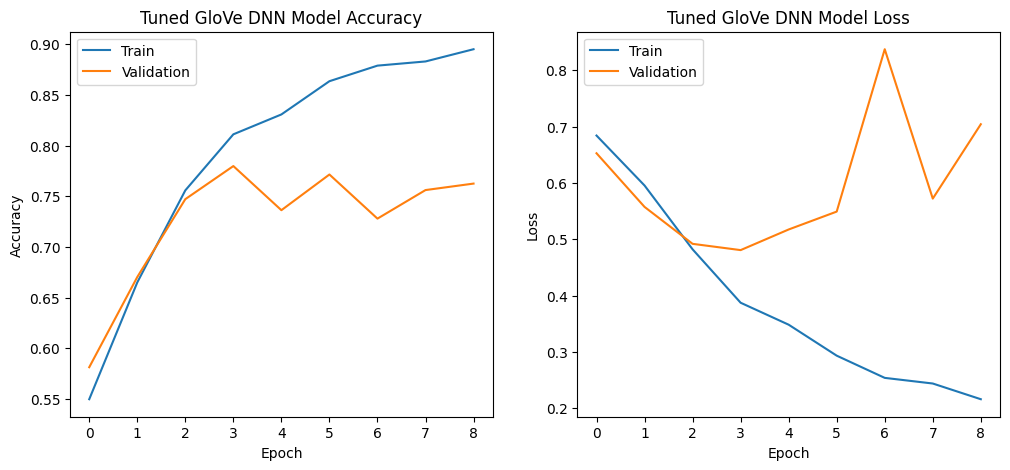

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_tuned_glove_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the tuned DNN model with GloVe embeddings
BATCH_SIZE = 32
EPOCHS = 100 # Set a higher number for early stopping to take effect

print("\nTraining tuned DNN model with trainable GloVe embeddings...")
history_tuned_glove = tuned_glove_model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Define the plot_history function if it's not already defined in the current scope
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title_prefix} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title_prefix} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training & validation history
plot_history(history_tuned_glove, title_prefix="Tuned GloVe DNN")



Evaluating tuned GloVe DNN model on test set...
Test Loss (Tuned GloVe DNN): 0.5112
Test Accuracy (Tuned GloVe DNN): 0.7716
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report (Tuned GloVe DNN):
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       739
           1       0.77      0.80      0.79       824

    accuracy                           0.77      1563
   macro avg       0.77      0.77      0.77      1563
weighted avg       0.77      0.77      0.77      1563


Confusion Matrix (Tuned GloVe DNN):
[[544 195]
 [162 662]]


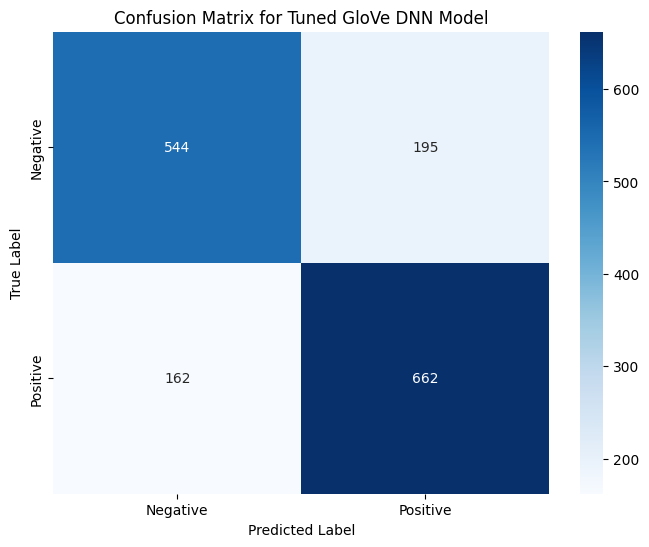

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluate the tuned model on the test set
print("\nEvaluating tuned GloVe DNN model on test set...")
loss_tuned_glove, accuracy_tuned_glove = tuned_glove_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss (Tuned GloVe DNN): {loss_tuned_glove:.4f}")
print(f"Test Accuracy (Tuned GloVe DNN): {accuracy_tuned_glove:.4f}")

# 2. Generate predictions for the test set and convert to binary labels
y_pred_proba_tuned_glove = tuned_glove_model.predict(X_test_pad)
y_pred_tuned_glove = (y_pred_proba_tuned_glove > 0.5).astype(int)

# 3. Print the classification report
print("\nClassification Report (Tuned GloVe DNN):")
print(classification_report(y_test, y_pred_tuned_glove))

# 4. Compute and print the confusion matrix
cm_tuned_glove = confusion_matrix(y_test, y_pred_tuned_glove)
print("\nConfusion Matrix (Tuned GloVe DNN):")
print(cm_tuned_glove)

# 5. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_glove, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned GloVe DNN Model')
plt.show()

*The DNN model uses trainable GloVe Embeddings slightly outperforming the Logistic Regression classifier. It achieves around 76% accuracy on the test set.*

# Model Improvement - Using BERT Transformer

In [ ]:
print("Installing transformers library...")
!pip install transformers
print("Transformers library installed.")

Installing transformers library...
Transformers library installed.


In [ ]:
import os

# Set the environment variable to use legacy Keras
os.environ['TF_USE_LEGACY_KERAS'] = 'True'
print("TF_USE_LEGACY_KERAS environment variable set to 'True'.")

TF_USE_LEGACY_KERAS environment variable set to 'True'.


In [ ]:
print("Installing tf_keras library...")
!pip install tf_keras
print("tf_keras library installed.")

Installing tf_keras library...
tf_keras library installed.


Loading tokenizer for bert-base-uncased...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.
Tokenizing X_train (length 7289)...
X_train tokenization complete.
Tokenizing X_val (length 1562)...
X_val tokenization complete.
Tokenizing X_test (length 1563)...
X_test tokenization complete.
BERT-encoded data shapes:
  X_train_encoded input_ids shape: (7289, 128)
  X_val_encoded input_ids shape:   (1562, 128)
  X_test_encoded input_ids shape:  (1563, 128)
Converting labels to TensorFlow tensors...
Labels converted.
BERT-encoded labels shapes:
  y_train_tf shape: (7289,)
  y_val_tf shape:   (1562,)
  y_test_tf shape:  (1563,)
Keras session cleared.
Loading TFAutoModelForSequenceClassification for bert-base-uncased with 2 labels...


Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.


tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.
Model compiled.
Callbacks initialized.

Training BERT model...
Epoch 1/5
228/228 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.7526

/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


228/228 [==============================] - 287s 999ms/step - loss: 0.4834 - accuracy: 0.7526 - val_loss: 0.4065 - val_accuracy: 0.8214
Epoch 2/5
228/228 [==============================] - 202s 884ms/step - loss: 0.2692 - accuracy: 0.8879 - val_loss: 0.5478 - val_accuracy: 0.8022
Epoch 3/5
228/228 [==============================] - 201s 880ms/step - loss: 0.1562 - accuracy: 0.9443 - val_loss: 0.5951 - val_accuracy: 0.8182
Epoch 4/5
228/228 [==============================] - 201s 881ms/step - loss: 0.0901 - accuracy: 0.9706 - val_loss: 0.6584 - val_accuracy: 0.8201
BERT model training complete.


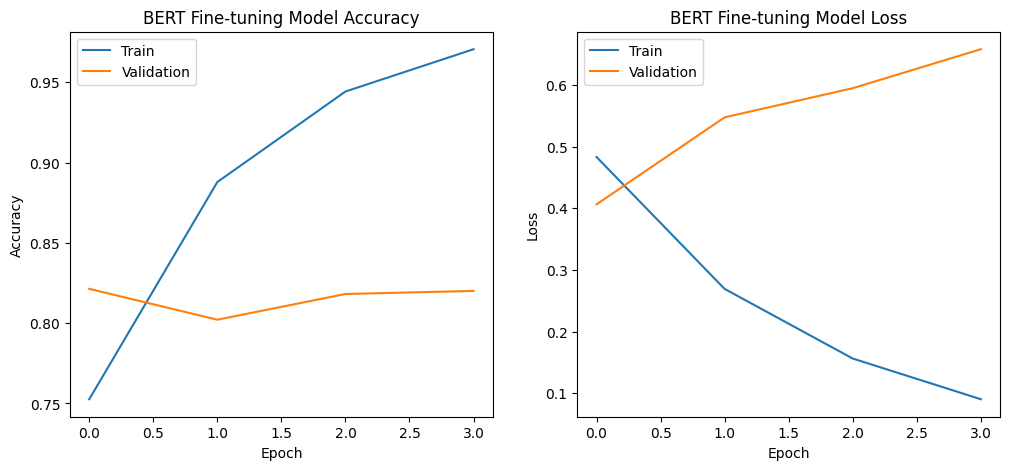


Evaluating BERT model on test set...
Test Loss (BERT): 0.4231
Test Accuracy (BERT): 0.8157

Generating predictions on test set...
49/49 [==============================] - 16s 283ms/step
Predictions generated.

Classification Report (BERT):
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       739
           1       0.81      0.85      0.83       824

    accuracy                           0.82      1563
   macro avg       0.82      0.81      0.81      1563
weighted avg       0.82      0.82      0.82      1563


Confusion Matrix (BERT):
[[577 162]
 [126 698]]


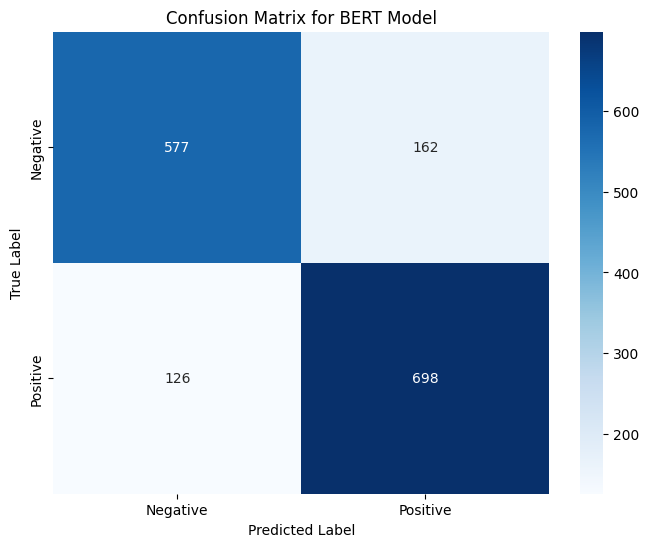

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras.optimizers import Adam # Import Adam from tf_keras

# 1. Define the pre-trained BERT model name and number of labels
MODEL_NAME = 'bert-base-uncased'
num_labels = 2 # For binary classification (positive/negative)

# 2. Define MAX_BERT_SEQUENCE_LEN
MAX_BERT_SEQUENCE_LEN = 128 # Common max length for BERT, adjust if necessary

# 3. Load the pre-trained BERT tokenizer
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

# 4. Tokenize the training, validation, and test text data
# X_train, X_val, X_test are already available from previous cells
print(f"Tokenizing X_train (length {len(X_train)})...")
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=MAX_BERT_SEQUENCE_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors='tf'
)
print("X_train tokenization complete.")

print(f"Tokenizing X_val (length {len(X_val)})...")
X_val_encoded = tokenizer.batch_encode_plus(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=MAX_BERT_SEQUENCE_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors='tf'
)
print("X_val tokenization complete.")

print(f"Tokenizing X_test (length {len(X_test)})...")
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_BERT_SEQUENCE_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors='tf'
)
print("X_test tokenization complete.")

print("BERT-encoded data shapes:")
print("  X_train_encoded input_ids shape:", X_train_encoded['input_ids'].shape)
print("  X_val_encoded input_ids shape:  ", X_val_encoded['input_ids'].shape)
print("  X_test_encoded input_ids shape: ", X_test_encoded['input_ids'].shape)

# 5. Convert the corresponding labels into TensorFlow tensors
# y_train, y_val, y_test are already available from previous cells
print("Converting labels to TensorFlow tensors...")
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)
print("Labels converted.")

print("BERT-encoded labels shapes:")
print("  y_train_tf shape:", y_train_tf.shape)
print("  y_val_tf shape:  ", y_val_tf.shape)
print("  y_test_tf shape: ", y_test_tf.shape)

# 6. Clear any previous Keras session
tf.keras.backend.clear_session()
print("Keras session cleared.")

# 7. Load the pre-trained BERT model for sequence classification
print(f"Loading TFAutoModelForSequenceClassification for {MODEL_NAME} with {num_labels} labels...")
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, use_safetensors=False)
print("Model loaded.")

# 8. Compile the BERT model
optimizer = Adam(learning_rate=2e-5) # Use Adam from tf_keras.optimizers
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
print("Model compiled.")

# 9. Initialize EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_bert_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
print("Callbacks initialized.")

# 10. Train the BERT model
BATCH_SIZE = 32
EPOCHS = 5 # Set a low number of epochs, early stopping will manage the actual duration

print("\nTraining BERT model...")
history_bert = model.fit(
    tf.data.Dataset.from_tensor_slices((dict(X_train_encoded), y_train_tf)).batch(BATCH_SIZE),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=tf.data.Dataset.from_tensor_slices((dict(X_val_encoded), y_val_tf)).batch(BATCH_SIZE),
    callbacks=[early_stopping, model_checkpoint]
)
print("BERT model training complete.")

# 11. Define the plot_history function if it's not already defined
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title_prefix} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title_prefix} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training & validation history
plot_history(history_bert, title_prefix="BERT Fine-tuning")

# 12. Evaluate the trained BERT model on the test set
print("\nEvaluating BERT model on test set...")
loss_bert, accuracy_bert = model.evaluate(
    tf.data.Dataset.from_tensor_slices((dict(X_test_encoded), y_test_tf)).batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print(f"Test Loss (BERT): {loss_bert:.4f}")
print(f"Test Accuracy (BERT): {accuracy_bert:.4f}")

# 13. Generate predictions for the test set and convert to binary labels
print("\nGenerating predictions on test set...")
y_pred_bert_logits = model.predict(tf.data.Dataset.from_tensor_slices(dict(X_test_encoded)).batch(BATCH_SIZE)).logits
y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)
print("Predictions generated.")

# 14. Print the classification report
print("\nClassification Report (BERT):")
print(classification_report(y_test_tf.numpy(), y_pred_bert))

# 15. Compute and print the confusion matrix
cm_bert = confusion_matrix(y_test_tf.numpy(), y_pred_bert)
print("\nConfusion Matrix (BERT):")
print(cm_bert)

# 16. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BERT Model')
plt.show()

*The BERT model outperforms the DNN Model. It achieves around 82% accuracy on the test set.*

## Try load the model and predict some sentences sentiment

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np

# Load the tokenizer
MODEL_NAME = 'bert-base-uncased'
MAX_BERT_SEQUENCE_LEN = 128
print(f"Loading tokenizer for {MODEL_NAME}...")
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

# Load the best BERT model weights
print("Loading the best BERT model weights...")

# 1. Instantiate the TFAutoModelForSequenceClassification from pre-trained weights
# This loads the architecture and initial weights compatible with the transformers library
# Explicitly set from_pt=False and use_safetensors=False to avoid potential conflicts
best_bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    from_pt=False, # Ensure it tries to load a TensorFlow checkpoint
    use_safetensors=False # Disable safetensors during initial load if it's causing issues
)

# 2. Load the fine-tuned weights from the locally saved .keras file
# This assumes the architecture of the loaded model matches the one saved.
# Make sure the file exists: 'models/best_bert_model.keras'
best_bert_model.load_weights('models/best_bert_model.keras')
print("Model weights loaded.")

def predict_sentiment_bert(sentence):
    # Tokenize the input sentence
    encoded_input = bert_tokenizer.batch_encode_plus(
        [sentence],
        add_special_tokens=True,
        max_length=MAX_BERT_SEQUENCE_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='tf'
    )

    # Make prediction
    # The loaded model returns an object that has a .logits attribute
    logits = best_bert_model(encoded_input).logits
    prediction = tf.argmax(logits, axis=1).numpy()[0]

    # Map prediction to sentiment label
    if prediction == 1:
        return "Positive"
    else:
        return "Negative"

print("\nSentiment prediction function created. Testing with examples:")

# Test the function with some example sentences
example_sentences = [
    "This movie was absolutely fantastic! I loved every moment of it.",
    "What a terrible experience. I regret wasting my time on this product.",
    "It's an okay book, nothing spectacular but not bad either.",
    "The customer service was excellent and the delivery was fast."
]

for sentence in example_sentences:
    sentiment = predict_sentiment_bert(sentence)
    print(f"Sentence: '{sentence}'\nPredicted Sentiment: {sentiment}\n")


Loading tokenizer for bert-base-uncased...
Tokenizer loaded.
Loading the best BERT model weights...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model weights loaded.

Sentiment prediction function created. Testing with examples:
Sentence: 'This movie was absolutely fantastic! I loved every moment of it.'
Predicted Sentiment: Positive

Sentence: 'What a terrible experience. I regret wasting my time on this product.'
Predicted Sentiment: Negative

Sentence: 'It's an okay book, nothing spectacular but not bad either.'
Predicted Sentiment: Negative

Sentence: 'The customer service was excellent and the delivery was fast.'
Predicted Sentiment: Positive



# To do 4: Create Web UI and integrate the model
Demo: https://isy503-group3-assessment3-t3-2025.streamlit.app/

# To do 5: Create presentation file